In [1]:
from skimage.io import imread,imsave,imshow
from matplotlib.pyplot import cm
from skimage.feature import peak_local_max
from scipy.ndimage import distance_transform_edt
from skimage.color import rgb2hed, rgb2hsv, rgb2gray
from skimage.filters import threshold_otsu, gaussian, sobel
from skimage.morphology import opening,closing,disk
from skimage.segmentation import mark_boundaries

import skimage.filters.rank as skr
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# Coding project - Tumour segmentation

The image below is a slice of a brain MRI with a large tumour in it. The goal of this project is to create an algorithm to automatically segment the tumour.

Given that the resolution of the image is of 0.115 cm/px in both axis, estimate the area of the tumour (in cm²). 

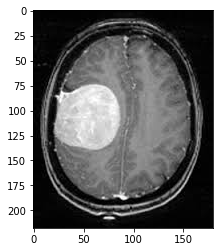

In [2]:
im = imread('mri_brain.jpg')

plt.figure()
plt.imshow(im)
plt.show()

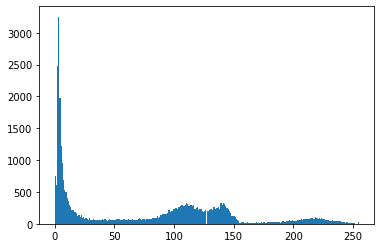

In [3]:


im = imread('mri_brain.jpg')
gray = rgb2gray(im)*255
plt.figure()
plt.hist(gray.flatten(), bins=257)
plt.show()

## Observation of the histogram
We can see from the histogram that computing an Otsu threshold wouldn't be the best idea because the region that interests us is very unrepresented.

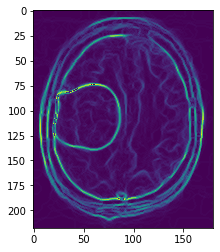

In [4]:
smoothing_factor = 5
im_r = skr.median(im[:,:,0], disk(smoothing_factor))
im_g = skr.median(im[:,:,1], disk(smoothing_factor))
im_b = skr.median(im[:,:,2], disk(smoothing_factor))

gradient_r = skr.gradient(im_r, disk(1))
gradient_g = skr.gradient(im_g, disk(1))
gradient_b = skr.gradient(im_b, disk(1))


grad = gradient_r+gradient_g+gradient_b

plt.imshow(grad)

/home/sami/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  """
/home/sami/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  app.launch_new_instance()
/home/sami/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  """
/home/sami/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_u

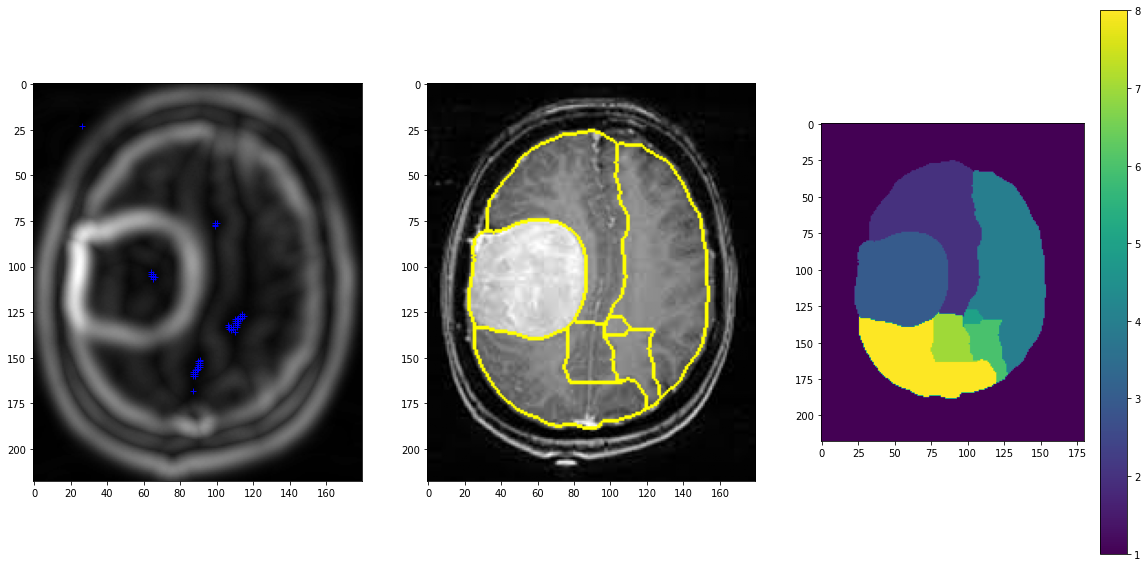

In [5]:
from skimage.feature import peak_local_max

def get_markers(im, indices=False):
    # Would also work with a median filter ! see above
    im_ = gaussian(im, sigma=4)
    gradr = skr.gradient(im_[:,:,0],disk(5)).astype('int')
    gradg = skr.gradient(im_[:,:,1],disk(5)).astype('int')
    gradb = skr.gradient(im_[:,:,2],disk(5)).astype('int')
    grad = gradr+gradg+gradb
    
    
    # The minimum distance we put here is influenced by the processing (here using gaussian filter)
    # If we used median filter, or if we changed the sigma, we should change the min_distance according to our observations
    return peak_local_max(grad.max()-grad,threshold_rel=0.5, min_distance=22,indices=indices),grad

markers,grad = get_markers(im, True)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(grad, cmap=plt.cm.gray)
plt.plot(markers[:,1],markers[:,0],'b+')
plt.subplot(1,3,2)


## Need to compute Markers with "indices" set to False
from skimage.measure import label
from skimage.segmentation import watershed
from skimage.segmentation import mark_boundaries
markers,grad = get_markers(im, False)
markers = label(markers)
ws = watershed(grad, markers)
boundaries = mark_boundaries(im,ws)
plt.imshow(boundaries)
plt.subplot(1,3,3)
plt.imshow(ws)
plt.colorbar()
plt.show()

### Tumor location
The tumor has one of the labels, we can see that it is the third $L = 3$

Total area : 46.075900000000004 cm^2


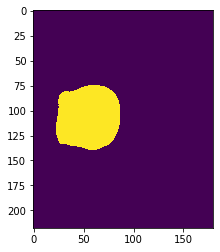

In [6]:
labels, counts = np.unique(ws, return_counts=True)
tumor = labels[2]
n_pixels = counts[2]
area_by_pixel = 0.115**2 # cm^2/px
total_area = n_pixels*area_by_pixel
print("Total area : {} cm^2".format(total_area))

plt.figure()
plt.imshow(ws==tumor)
plt.show()

